*Pipeline* que é como esperamos que faremos o estudo <br>
João Pedro Meirelles <br>
Pedro Daher <br>
Pedro Vero Fontes <br>
Jose Helio <br>
<b>Objetivo da entrega, chegar no teste de hipotese, explicar tudo, resumindo, um codigo bem explicado</b>

Comeco de tudo, precisamos de uma hipotese bem feita.

# Hipotese
### Interacao 1
Personagem com poderes mais raros, tendem a ser mais populares (aparecer mais em comics).

### Interacao 2
Poderes mais raros geram um senso maior de importancia, pois são coisas que só ele consegue fazer, assim em certas situacoes onde tal poder eh necessario, menos super-herois poder ser inseridos pois o poder necessario eh mais raro.

### Interacao 3
Como comics tem sempre um problema, ou vilao a ser derrotado, gera sempre necessidade de inumeros poderes serem utilizados, assim, quanto menos personagens terem os mesmos poderes ou semelhantes, mais vezes o personagem que possui um poder raro precisara ser chamado.

## Preparacao
Pra que consigamos fazer nossa rede, precisamos primeiro montar uma tabla com os dados quantitativos, então os dados de cross over, pegando a tabela com os comics e os personagens dentro dela.

Em conjunto com isso precisamos fazer tambem uma tabela apenas com os poderes e contabilizando quais poderes aparecem mais que outros, criando o que eu decrevi como "Unicos", que em jargões, seria degree talvez.

Com as duas tabelas criadas acima, podemos então montar uma rede entre os personagens que aparecem em comics iguais, e tambem montar uma rede de personagens que aparecem em comics iguais e poderes.

## Estudo das redes
Na preparacao a gente "montou" duas tabelas principais pra montar a rede de nosso interesse, e com essa rede esperamos identificar algumas coisas.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from scipy import stats
import freeman as fm
import statsmodels.api as sn
import matplotlib.pyplot as plt

In [2]:
from csv import reader
from unidecode import unidecode
import itertools

personagens = {}
herois = {}
per_comics = {}
personagens_weight = {}
comics_degree = {}
edges_dic = {}
edges_duplicates = 0
comics = {}
poderes = {}

with open("characters.csv",encoding="utf-8") as file:
    file.readline()
    for i, row in enumerate(reader(file), 2):
        charId = row[0]
        nome = row[1]
        personagens[int(charId)] = nome
        personagens_weight[charId] = 1

with open("charcters_stats.csv",encoding="utf-8") as file:
    file.readline()
    for i, row in enumerate(reader(file), 2):
        nome = row[0]
        alinhamento = row[1]
        if alinhamento=="good":
            herois[nome] = row[2:8]
            herois[nome] = [int(i) for i in herois[nome]] 
        

with open("comics.csv",encoding="utf-8") as file:
    file.readline()
    for i, row in enumerate(reader(file), 2):
        comicId = row[0]
        title = row[1]
        comics[int(comicId)] = title
        comics_degree[comicId] = 1
# Dictionari with {"Comic_ID":[List with all charecter_id there]}
with open("charactersToComics.csv",encoding="utf-8") as file:
    file.readline()
    i = 0;
    for i, row in enumerate(reader(file), 2):
        if personagens[int(row[1])] in herois:
            if row[0] in per_comics:
                per_comics[row[0]].append(personagens[int(row[1])])
            else:
                per_comics[row[0]] = [personagens[int(row[1])]]

a = len(edges_dic)
edges_dic2 = {tuple(v): k for k, v in edges_dic.items()}# Remove duplicatas das edges
edges_dic = {v: list(k) for k, v in edges_dic2.items()}
edges = edges_dic.values()

In [3]:
print(f'''
Numero de personagens {len(personagens)}\n
Numero de Hérois {len(herois)}\n
Numero de comics {len(comics)}\n
Numero de arestas {len(edges)}
''')


Numero de personagens 1170

Numero de Hérois 431

Numero de comics 38875

Numero de arestas 0



# Construindo a nossa TwoMode - Especialistas

In [4]:
df_herois = pd.concat({k: pd.Series(v) for k, v in herois.items()}, axis=1).T
df_herois.columns = ["Intelligence","Strength","Speed","Durability","Power","Combat"]


velocistas = df_herois[df_herois["Speed"] > df_herois["Speed"].mean() + 2.88 * df_herois["Speed"].std()]
sabichoes = df_herois[df_herois["Intelligence"] > df_herois["Intelligence"].mean() + 1.82 * df_herois["Intelligence"].std()]
parrudos = df_herois[df_herois["Strength"] > df_herois["Strength"].mean() + 2.29 * df_herois["Strength"].std()]
duro_na_queda = df_herois[df_herois["Durability"] > df_herois["Durability"].mean() + 1.7 * df_herois["Durability"].std()]
show_das_poderosas = df_herois[df_herois["Power"] > df_herois["Power"].mean() + 1.8 * df_herois["Power"].std()]
bons_de_briga = df_herois[df_herois["Combat"] > df_herois["Combat"].mean() + 1.73 * df_herois["Combat"].std()]

df_herois['velocistas'] = df_herois['Speed'].apply(lambda x: 1 if x >= 100 else 0)
df_herois['sabichoes'] = df_herois['Intelligence'].apply(lambda x: 1 if x >= 100 else 0)
df_herois['parrudos'] = df_herois['Strength'].apply(lambda x: 1 if x >= 100 else 0)
df_herois['duro_na_queda'] = df_herois['Durability'].apply(lambda x: 1 if x >= 100 else 0)
df_herois['show_das_poderosas'] = df_herois['Power'].apply(lambda x: 1 if x >= 100 else 0)
df_herois['bons_de_briga'] = df_herois['Combat'].apply(lambda x: 1 if x >= 100 else 0)
df_herois

,Intelligence,Strength,Speed,Durability,Power,Combat,velocistas,sabichoes,parrudos,duro_na_queda,show_das_poderosas,bons_de_briga
3-D Man,50,31,43,32,25,52,0,0,0,0,0,0
A-Bomb,38,100,17,80,17,64,0,0,1,0,0,0
Abe Sapien,88,14,35,42,35,85,0,0,0,0,0,0
Abin Sur,50,90,53,64,84,65,0,0,0,0,0,0
Adam Monroe,63,10,12,100,71,64,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
X-Man,88,53,53,95,92,84,0,0,0,0,0,0
Yellowjacket,88,10,12,28,12,14,0,0,0,0,0,0
Yellowjacket II,50,10,35,28,31,28,0,0,0,0,0,0
Ymir,50,100,27,100,83,28,0,0,1,1,0,0


# Construindo a nossa TwoMode - Participações

In [5]:
lista_herois = [i for i in herois]
lista_herois[:10]

['3-D Man',
 'A-Bomb',
 'Abe Sapien',
 'Abin Sur',
 'Adam Monroe',
 'Adam Strange',
 'Agent  13',
 'Agent Bob',
 'Agent Zero',
 'Alan Scott']

In [6]:
len(lista_herois)

431

In [7]:
herois = []
heroes = [str(personagens[x]) for x in personagens if (str(personagens[x]) in lista_herois) and (str(personagens[x])!='Jean Grey')]
heroes.append('Jean Grey')
heroes[:10]

['Captain America',
 'Winter Soldier',
 'Nick Fury',
 'Punisher',
 'Beast',
 'Colossus',
 'Cyclops',
 'Emma Frost',
 'Wolverine',
 'Spider-Man']

In [8]:
len(heroes)

141

In [9]:
'Wolverine' in heroes

True

In [10]:
quadrinhos = [str(x) for x in per_comics]

df_f = {}

for q in quadrinhos:
    l = []
    for h in heroes:

        if h in per_comics[q]:
            l.append(1)
        else: 
            l.append(0)
        
        if 1 in l:
            df_f[q] = l

df = pd.DataFrame(df_f, index=heroes)

df

,16232,16248,58634,16241,17486,16234,10511,27238,16236,69098,...,43508,43303,45880,46412,46721,46641,45824,46509,46047,46210
Captain America,1,1,0,1,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
Winter Soldier,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nick Fury,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Punisher,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Beast,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agent Zero,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Toxin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shriek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Leech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_especialistas = df_herois[['velocistas','sabichoes','parrudos','duro_na_queda','show_das_poderosas','bons_de_briga']].copy()
df_especialistas = df_especialistas.drop(index=df_especialistas.index.difference(heroes))
df_especial = df_especialistas
df_especial

,velocistas,sabichoes,parrudos,duro_na_queda,show_das_poderosas,bons_de_briga
3-D Man,0,0,0,0,0,0
Agent Zero,0,0,0,0,0,0
Arachne,0,0,0,0,0,0
Archangel,0,0,0,0,0,0
Ares,0,0,0,0,0,1
...,...,...,...,...,...,...
Wolfsbane,0,0,0,0,0,0
Wolverine,0,0,0,1,0,1
Wonder Man,0,0,1,0,0,0
X-23,0,0,0,0,0,0


# Convertendo a TwoMode em OneMode

In [12]:
matrix_especialistas = df_especial.to_numpy()
matrix_especialistas = matrix_especialistas.dot(matrix_especialistas.T)

df_especialistas = pd.DataFrame(matrix_especialistas)
df_especialistas.columns = df_especial.index.values
df_especialistas.index = df_especial.index.values


matrix_ape = df.to_numpy()
matrix_ape = matrix_ape.dot(matrix_ape.T)

df_ape = pd.DataFrame(matrix_ape)
df_ape.columns = heroes
df_ape.index = heroes
# df_ape

In [13]:
df_especialistas

,3-D Man,Agent Zero,Arachne,Archangel,Ares,Aurora,Banshee,Beak,Beast,Beyonder,...,Vision,Warbird,Warpath,Wasp,Winter Soldier,Wolfsbane,Wolverine,Wonder Man,X-23,X-Man
3-D Man,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agent Zero,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arachne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Archangel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ares,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wolfsbane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Wolverine,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,2,0,0,0
Wonder Man,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
X-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Passando para GML

In [14]:
# function to return key for any value 
def get_key(my_dict, val): 
    for key, value in my_dict.items(): 
         if val == value: 
             return key 
  
    return "key doesn't exist"

dic_espec = {}
hid = 0
temp = 0
for columns in heroes:
    for rows in heroes: 
        peso = df_especialistas[columns][rows]
        # if float(peso)>=1.0:
        temp += 1
    if temp>=1:
        dic_espec[hid] = columns
        hid += 1
        
dic_ape = {}
hid2 = 0
temp2 = 0
for columns in heroes:
    for rows in heroes: 
        peso2 = df_ape[columns][rows]
        # if float(peso2)>=1.0:
        temp2 += 1
    if temp2>=1:
        dic_ape[hid2] = columns
        hid2 += 1

In [15]:
special = "!#$%&'()*+,.:;<=>?@[\]^_`{|}~â€”¨“";
num_exc = 0
with open('especialistas.gml','w+') as file:
    file.write('graph [\n')
    file.write('    directed 1\n')
    for char in dic_espec: # Cria os nodes dos personagens
        if '"' in dic_espec[char]: # Remove aspas duplas
            dic_espec[char] = dic_espec[char].replace('"',"")
        # if '-' in char: # Remove aspas duplas
        #     char = char.replace('-'," ")
        for i in special:
            if i in dic_espec[char]:  # Remove caracteres especiais
                dic_espec[char] = dic_espec[char].replace(i,"")
        file.write('    node [\n')
        file.write(f'        id {int(char)}\n')
        file.write(f'        name "{unidecode(dic_espec[char])}"\n')
        file.write('        tipo "heroi"\n')
        file.write('    ]\n')
    
    for columns in heroes:
        for rows in heroes: 
            peso = df_especialistas[columns][rows]
            if float(peso)>=1.0 and columns!=rows:
                
                if '"' in columns: # Remove aspas duplas
                    columns = columns.replace('"',"")
                for i in special:
                    if i in columns:  # Remove caracteres especiais
                        columns = columns.replace(i,"")
                if '"' in rows: # Remove aspas duplas
                    rows = rows.replace('"',"")
                for i in special:
                    if i in rows:  # Remove caracteres especiais
                        rows = rows.replace(i,"")
                # Monta as ligacoes entre nodes
                file.write('    edge [\n')
                file.write(f'        source {int(get_key(dic_espec,rows))}\n')
                file.write(f'        target {int(get_key(dic_espec,columns))}\n')
                file.write(f'        weight {float(peso)}')
                file.write('    ]\n')
    file.write(']\n') # Fecha o graph
    
with open('ape.gml','w+') as file:
    file.write('graph [\n')
    file.write('    directed 1\n')
    for char in dic_ape: # Cria os nodes dos personagens
        if '"' in dic_ape[char]: # Remove aspas duplas
            dic_ape[char] = dic_ape[char].replace('"',"")
        # if '-' in char: # Remove aspas duplas
        #     char = char.replace('-'," ")
        for i in special:
            if i in dic_ape[char]:  # Remove caracteres especiais
                dic_ape[char] = dic_ape[char].replace(i,"")
        file.write('    node [\n')
        file.write(f'        id {int(char)}\n')
        file.write(f'        name "{unidecode(dic_ape[char])}"\n')
        file.write('        tipo "heroi"\n')
        file.write('    ]\n')
    
    for columns in heroes:
        for rows in heroes: 
            peso = df_ape[columns][rows]
            if float(peso)>=1.0 and columns!=rows:
                
                if '"' in columns: # Remove aspas duplas
                    columns = columns.replace('"',"")
                for i in special:
                    if i in columns:  # Remove caracteres especiais
                        columns = columns.replace(i,"")
                if '"' in rows: # Remove aspas duplas
                    rows = rows.replace('"',"")
                for i in special:
                    if i in rows:  # Remove caracteres especiais
                        rows = rows.replace(i,"")
                # Monta as ligacoes entre nodes
                file.write('    edge [\n')
                file.write(f'        source {int(get_key(dic_ape,rows))}\n')
                file.write(f'        target {int(get_key(dic_ape,columns))}\n')
                file.write(f'        weight {float(peso)}')
                file.write('    ]\n')
    file.write(']\n') # Fecha o graph

In [16]:
# weight_lim (0 a 1)
# character_degree_limit numero
# comic_degree_limit numero
# g = load(weight_lim=0.2)
espec = fm.load("especialistas.gml")
ape = fm.load("ape.gml")

In [17]:
espec.draw()

<h2>Formulas uteis (Aula 4)</h2>

In [18]:
from math import log

def proportion(g, n, m):
    return 1 / g.degree(n)

def local_effsize(g, n, m):
    s = 1
    for k in g.neighbors(n):
        if g.has_edge(k, m):
            s -= proportion(g, n, k)
    return s

def effsize(g, n):
    s = 0
    for m in g.neighbors(n):
        s += local_effsize(g, n, m)
    return s

def local_constraint(g, n, m):
    s = proportion(g, n, m)
    for k in g.neighbors(n):
        if g.has_edge(k, m):
            s += proportion(g, n, k) * proportion(g, k, m)
    return s**2

def constraint(g, n):
    if g.degree(n) == 0:
        return 2
    s = 0
    for m in g.neighbors(n):
        s += local_constraint(g, n, m)
    return s

def hierarchy(g, n):
    c = constraint(g, n)
    N = g.number_of_nodes()
    s = 0
    for m in g.neighbors(n):
        f = local_constraint(g, n, m) / (c / N)
        s += f * log(f)
    return s / (N * log(N))

In [19]:
print('calculando centralidade degree...')
dc = nx.degree_centrality(espec)

print('calculando centralidade betweenness...')
bc = nx.betweenness_centrality(espec)

print('calculando centralidade closeness...')
cc = nx.closeness_centrality(espec)

print('calculando centralidade eigenvector...')
ec = nx.eigenvector_centrality(espec)

print('calculando centralidade degree...')
dc_ape = nx.degree_centrality(ape)

print('calculando centralidade betweenness...')
bc_ape = nx.betweenness_centrality(ape)

print('calculando centralidade closeness...')
cc_ape = nx.closeness_centrality(ape)

print('calculando centralidade eigenvector...')
ec_ape = nx.eigenvector_centrality(ape)

calculando centralidade degree...
calculando centralidade betweenness...
calculando centralidade closeness...
calculando centralidade eigenvector...
calculando centralidade degree...
calculando centralidade betweenness...
calculando centralidade closeness...
calculando centralidade eigenvector...


Calculando metricas novas

In [20]:
print('calculando efficient size...')
eff = {}
for n in espec.nodes:
    eff[n] = effsize(espec, n)

print('calculando constraint...')
con = {}
for n in espec.nodes:
    con[n] = constraint(espec, n)

print('calculando hierarchy...')
hie = {}
for n in espec.nodes:
    hie[n] = hierarchy(espec, n)

print('calculando efficient size...')
eff_ape = {}
for n in espec.nodes:
    eff_ape[n] = effsize(ape, n)

print('calculando constraint...')
con_ape = {}
for n in espec.nodes:
    con_ape[n] = constraint(ape, n)

print('calculando hierarchy...')
hie_ape = {}
for n in espec.nodes:
    hie_ape[n] = hierarchy(ape, n)

calculando efficient size...
calculando constraint...
calculando hierarchy...
calculando efficient size...
calculando constraint...
calculando hierarchy...


Armazena dados num DataFrame

In [21]:
data = pd.DataFrame({
    'nodes': [n for n in espec.nodes],
    'tipo': [espec.nodes[n]['tipo'] for n in espec.nodes],
    'name': [espec.nodes[n]['name'] for n in espec.nodes],
    'degree centrality': [dc[n] for n in espec.nodes],
    'betweenness centrality': [bc[n] for n in espec.nodes],
    'closeness centrality': [cc[n] for n in espec.nodes],
    'eigenvector centrality': [ec[n] for n in espec.nodes],
    'efficient size': [eff[n] for n in espec.nodes],
    'constraint': [con[n] for n in espec.nodes],
    'hierarchy': [hie[n] for n in espec.nodes],
})

data_ape = pd.DataFrame({
    'nodes': [n for n in ape.nodes],
    'tipo': [ape.nodes[n]['tipo'] for n in ape.nodes],
    'name': [ape.nodes[n]['name'] for n in ape.nodes],
    'degree centrality': [dc_ape[n] for n in ape.nodes],
    'betweenness centrality': [bc_ape[n] for n in ape.nodes],
    'closeness centrality': [cc_ape[n] for n in ape.nodes],
    'eigenvector centrality': [ec_ape[n] for n in ape.nodes],
    'efficient size': [eff_ape[n] for n in ape.nodes],
    'constraint': [con_ape[n] for n in ape.nodes],
    'hierarchy': [hie_ape[n] for n in ape.nodes],
})

fm.resize_all_plots(800, 1000)

print(len(data['efficient size']))
print(len(data['degree centrality']))
print(len(data_ape['degree centrality']))

141
141
141


In [22]:
model = sn.OLS(data_ape['degree centrality'], data[['closeness centrality', 'efficient size']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      degree centrality   R-squared (uncentered):                   0.273
Model:                            OLS   Adj. R-squared (uncentered):              0.262
Method:                 Least Squares   F-statistic:                              26.05
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    2.46e-10
Time:                        15:24:20   Log-Likelihood:                         -173.65
No. Observations:                 141   AIC:                                      351.3
Df Residuals:                     139   BIC:                                      357.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
closeness centrality    11.5679      4.005      2.889      0.004       3.650      19.486
efficient size          -0.0561      0.061     -0.915      0.362      -0.177       0.065
==============================================================================
Omnibus:                        8.570   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.438
Skew:                          -0.524   Prob(JB):                       0.0147
Kurtosis:                       3.582   Cond. No.                         233.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
model = sn.OLS(data_ape['degree centrality'], data[['efficient size']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      degree centrality   R-squared (uncentered):                   0.229
Model:                            OLS   Adj. R-squared (uncentered):              0.223
Method:                 Least Squares   F-statistic:                              41.58
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    1.71e-09
Time:                        15:24:20   Log-Likelihood:                         -177.76
No. Observations:                 141   AIC:                                      357.5
Df Residuals:                     140   BIC:                                      360.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
efficient size     0.1138      0.018      6.448      0.000       0.079       0.149
==============================================================================
Omnibus:                       13.660   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.543
Skew:                          -0.651   Prob(JB):                     0.000422
Kurtosis:                       3.975   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
model = sn.OLS(data_ape['degree centrality'], data[['degree centrality', 'efficient size']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      degree centrality   R-squared (uncentered):                   0.238
Model:                            OLS   Adj. R-squared (uncentered):              0.227
Method:                 Least Squares   F-statistic:                              21.76
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    6.00e-09
Time:                        15:26:04   Log-Likelihood:                         -176.89
No. Observations:                 141   AIC:                                      357.8
Df Residuals:                     139   BIC:                                      363.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
degree centrality     9.8547      7.504      1.313      0.191      -4.981      24.691
efficient size       -0.1063      0.169     -0.631      0.529      -0.439       0.227
==============================================================================
Omnibus:                       12.552   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.685
Skew:                          -0.634   Prob(JB):                      0.00107
Kurtosis:                       3.848   Cond. No.                         426.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model = sn.OLS(data_ape['degree centrality'], data[['closeness centrality']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      degree centrality   R-squared (uncentered):                   0.268
Model:                            OLS   Adj. R-squared (uncentered):              0.263
Method:                 Least Squares   F-statistic:                              51.33
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    4.08e-11
Time:                        15:48:31   Log-Likelihood:                         -174.07
No. Observations:                 141   AIC:                                      350.1
Df Residuals:                     140   BIC:                                      353.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
closeness centrality     8.0500      1.124      7.164      0.000       5.829      10.271
==============================================================================
Omnibus:                       10.381   Durbin-Watson:                   0.793
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.840
Skew:                          -0.564   Prob(JB):                      0.00443
Kurtosis:                       3.756   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model = sn.OLS(data_ape['degree centrality'], data[['degree centrality']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      degree centrality   R-squared (uncentered):                   0.236
Model:                            OLS   Adj. R-squared (uncentered):              0.231
Method:                 Least Squares   F-statistic:                              43.31
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                    8.67e-10
Time:                        15:50:24   Log-Likelihood:                         -177.09
No. Observations:                 141   AIC:                                      356.2
Df Residuals:                     140   BIC:                                      359.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
degree centrality     5.1479      0.782      6.581      0.000       3.601       6.694
==============================================================================
Omnibus:                       12.960   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.419
Skew:                          -0.637   Prob(JB):                     0.000740
Kurtosis:                       3.913   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

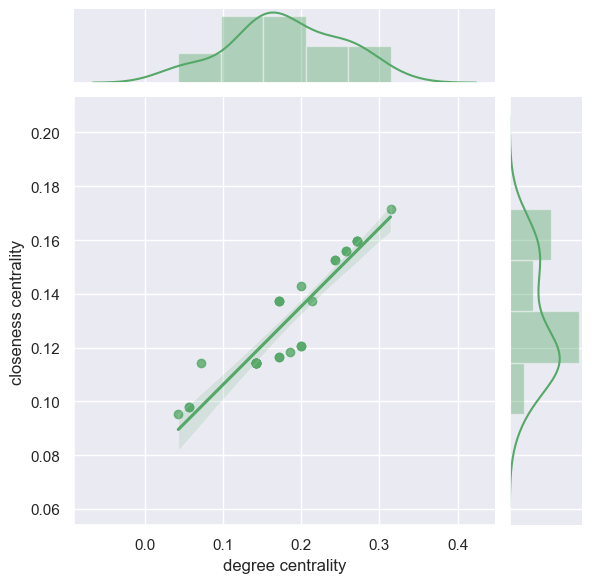

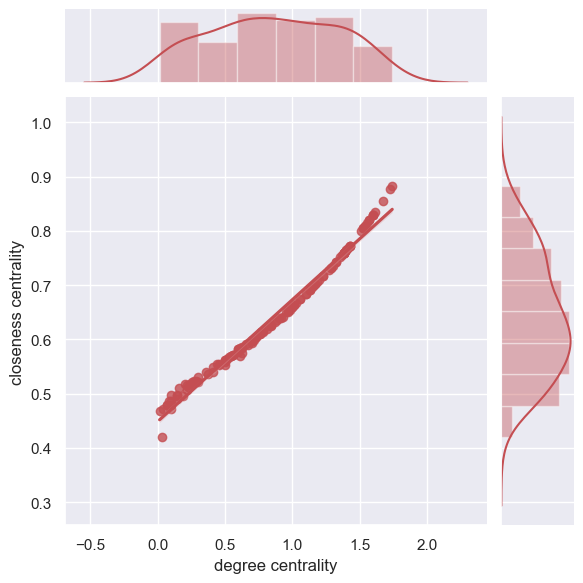

In [29]:
data_badass = data.loc[data['degree centrality']>0.0]
data_bape = data_ape.loc[data_ape['degree centrality']>0.0]
sns.jointplot(data=data_badass, y='closeness centrality', x='degree centrality', kind='reg', color='g');
sns.jointplot(data=data_bape, y='closeness centrality', x='degree centrality', kind='reg', color='r');
plt.show()

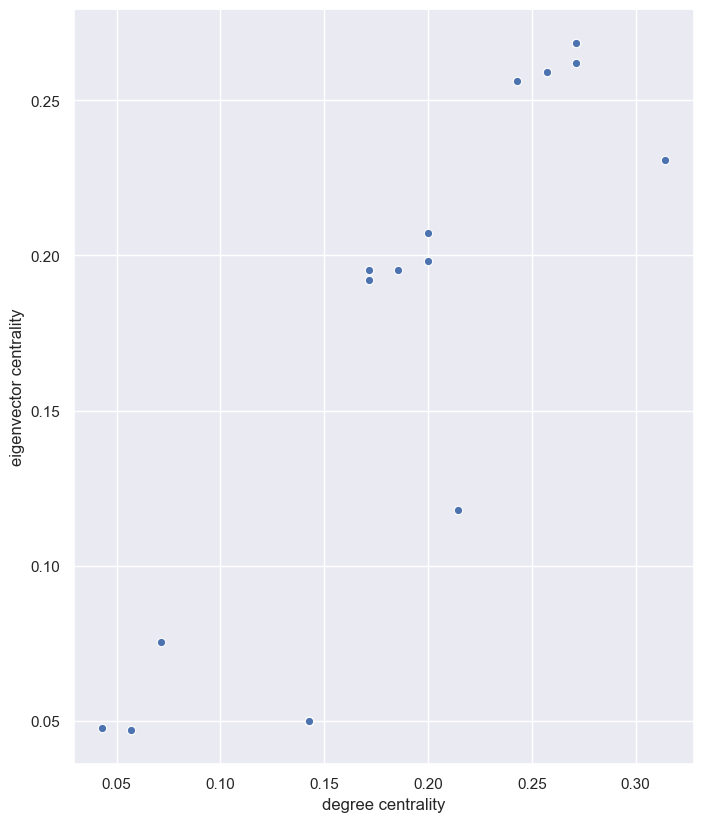

In [25]:
data_badass = data.loc[data['degree centrality']>0.0]
sns.scatterplot(data=data_badass, y='eigenvector centrality', x='degree centrality');

In [26]:
data_try = data.loc[data['eigenvector centrality']>0.14]

# Talvez seja útil depois

In [27]:
# df = pd.DataFrame.from_dict(personagens_weight.values())
# media_dos_pesos = int(df.mean())
# max_dos_pesos = int(df.max())
# df.describe()

# df = pd.DataFrame.from_dict(comics_degree.values())
# media_dos_degrees = int(df.mean())
# max_dos_degrees = int(df.max())
# df.describe()

# special = "!#$%&'()*+,-.:;<=>?@[\]^_`{|}~â€”¨“";
# num_exc = 0
# with open('charComic.gml','w+') as file:
#     file.write('graph [\n')
#     file.write('    directed 1\n')
#     for char in personagens.keys(): # Cria os nodes dos personagens
#         if '"' in personagens[char]: # Remove aspas duplas
#             personagens[char] = personagens[char].replace('"',"")
#         for i in special:
#             if i in personagens[char]:  # Remove caracteres especiais
#                 personagens[char] = personagens[char].replace(i,"")
#         file.write('    node [\n')
#         file.write(f'        id {int(char)}\n')
#         file.write(f'        name "{unidecode(personagens[char])}"\n')
#         file.write('        tipo "character"\n')
#         file.write(f'        degree {personagens_weight[str(char)]}\n')
#         file.write('    ]\n')
        
#     for comic in comics.keys(): # Cria os nodes dos comics
#         if '"' in comics[comic]: # Remove aspas duplas
#             comics[comic] = comics[comic].replace('"',"")
#         for i in special:
#             if i in comics[comic]: # Remove caracteres especiais
#                 comics[comic] = comics[comic].replace(i,"")
#         file.write('    node [\n')
#         file.write(f'        id {int(comic)}\n')
#         file.write(f'        name "{unidecode(comics[comic])}"\n')
#         file.write('        tipo "comic"\n')
#         file.write(f'        degree {comics_degree[str(comic)]}\n')
#         file.write('    ]\n')
        
#     pesos = {}
#     for p in personagens_weight:
#         pesos[p] = personagens_weight[p]/max_dos_pesos
#     personagens_weight = pesos
    
#     for t, s in edges:        # Monta as ligacoes entre nodes
#         file.write('    edge [\n')
#         file.write(f'        source {int(s)}\n')
#         file.write(f'        target {int(t)}\n')
#         file.write(f'        weight {float(personagens_weight[s])}')
#         file.write('    ]\n')
#     file.write(']\n') # Fecha o graph

# def calcularPesoComic(id_comic, personagens, edges):
#     peso_comic = 0
#     for c, p in edges:
#         if c == id_comic:
            
            

# def load(weight_lim = 0.5, character_degree_limit=media_dos_pesos,comic_degree_limit=media_dos_degrees):
#     g = fm.load('charComic.gml')

#     # Remover todas as arestas com peso menor ou igual a 0.5.
#     # Precisamos de dois loops, pois não é uma boa ideia
#     # tirar algo de um conjunto enquanto iteramos nele.
#     removed = []
#     for n, m in g.edges:
#         if g.edges[n, m]['weight'] <= weight_lim:
#             removed.append((n, m))
#     for n, m in removed:
#         g.remove_edge(n, m)

#     # Remover todos os nós que ficaram isolados depois da
#     # remoção das arestas, para melhorar a visualização.
#     removed = []
#     for n in g.nodes:
#         if not g.degree(n):
#             removed.append(n)
#         elif (g.degree(n) < character_degree_limit) & (g.nodes[n]['tipo'] == "character"):
#             removed.append(n)
#         elif (g.degree(n) < comic_degree_limit) & (g.nodes[n]['tipo'] == "comic"):
#             removed.append(n)
#     for n in removed:
#         g.remove_node(n)
    
#     for n in g.nodes:
#         if g.nodes[n]['tipo'] == "character":
#             g.nodes[n]['color'] = (0,0,255)
#         elif g.nodes[n]['tipo'] == "comic":
#             g.nodes[n]['color'] = (255,0,0)
#         else:
#             print("node sem tipo...")
        
#     return g

# def draw(g):
#     # Deixar os nós menores e fazer os nomes deles
#     # aparecer apenas quando o mouse passa por cima.
#     g.set_all_nodes(size=10, labpos='hover')

#     # Deixar as arestas semi-transparentes para
#     # a visualização ficar um pouco mais leve.
#     g.set_all_edges(color=(0, 0, 0, 0.25))

#     # Usar um algoritmo especial para posicionar
#     # os nós de acordo com grupos.
#     g.move('kamada_kawai')

#     g.draw()

# Notas do charles

- agregar variavel de controle degree na rede badass
    - regressao dela com degree comic
    